In [ ]:
!pip install geopandas planetary_computer pystac_client dask dask_geopandas shapely contextily adlfs mapclassify folium


In [2]:
# Requirements
import geopandas as gpd
import pandas as pd
import planetary_computer
import pystac_client
import adlfs
import dask.dataframe as ddf
import dask_geopandas
import dask.distributed
import shapely.geometry
import contextily
import matplotlib.pyplot as plt
from mapclassify import classify
import folium

In [3]:
#Connection String to Microsoft Planetart Computer API
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [4]:
#Buildings Footprint layer in Ecuador
items = catalog.search(
    collections=["ms-buildings"], query={"msbuildings:region": {"eq": "Ecuador"}}
)
item = next(items.items())
item

ID: Ecuador_2022-07-06
"Bounding Box: [-81.01024199, -4.988954552, -75.31666317, 1.372664229]"
title: Building footprints
datetime: None
description: Parquet dataset with the building footprints
end_datetime: 2020-11-24T00:00:00+00:00
"table:columns: [{'name': 'geometry', 'type': 'byte_array', 'description': 'Building footprint polygons'}]"
start_datetime: 2015-11-18T00:00:00+00:00
table:row_count: 643652
msbuildings:region: Ecuador
stac_extensions: ['https://stac-extensions.github.io/table/v1.2.0/schema.json']


In [5]:
#Read the geoparquet
asset = item.assets["data"]
ecuador = dask_geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
ecuador

,geometry,RegionName,quadkey
npartitions=55,,,
,geometry,category[known],category[known]
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [6]:
#Check the number of partitions and columns
partitions = ecuador.partitions[:1]
partitions.head()

,geometry,RegionName,quadkey
0,"POLYGON ((-78.86178 1.44687, -78.86177 1.44693...",Ecuador,32223313
1,"POLYGON ((-78.86255 1.44522, -78.86256 1.44527...",Ecuador,32223313
2,"POLYGON ((-78.86142 1.44567, -78.86138 1.44565...",Ecuador,32223313
3,"POLYGON ((-78.86178 1.44675, -78.86168 1.44674...",Ecuador,32223313
4,"POLYGON ((-78.86151 1.44528, -78.86150 1.44538...",Ecuador,32223313


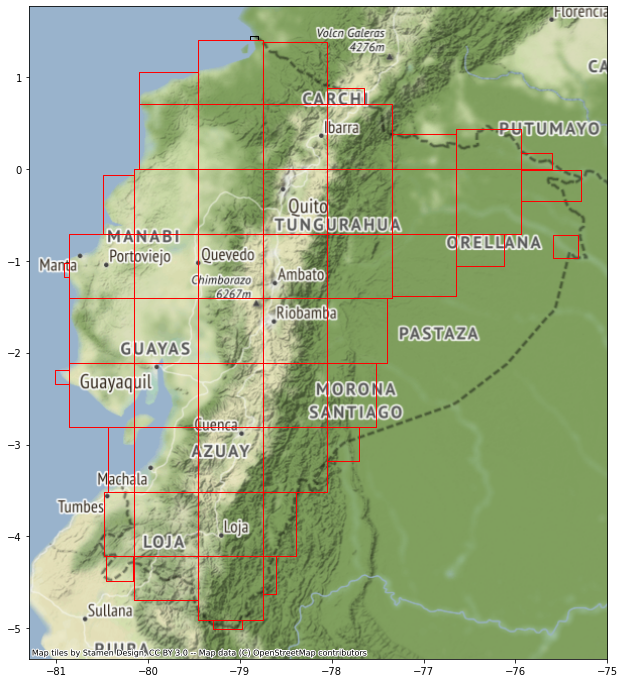

In [7]:
#Ecuador's Continental Territory bounding box
mask_ec = shapely.geometry.box(-81.01024199, -4.988954552, -75.31666317, 1.372664229)

#Plot the partitions
fig, ax = plt.subplots(figsize=(12, 12))
color = ["r" if x else "k" for x in ecuador.spatial_partitions.intersects(mask_ec)]
ecuador.spatial_partitions.plot(facecolor="none", edgecolor=color, ax=ax)
contextily.add_basemap(ax, crs=ecuador.crs.to_string())

In [11]:
#Read and format Shape Files
labota_shp = gpd.read_file("/content/drive/MyDrive/Diversa/LaBota.shp")
labota_shp.crs = {'proj': 'utm',
           'zone': 17,
           'south': True,
           'datum': 'WGS84',
           'units': 'm',
           'no_defs': True}
labota_shp = labota_shp.to_crs('epsg:4326') # lat lon format
toctiuco_shp = gpd.read_file("/content/drive/MyDrive/Diversa/Toctiuco.shp")
toctiuco_shp.crs = {'proj': 'utm',
           'zone': 17,
           'south': True,
           'datum': 'WGS84',
           'units': 'm',
           'no_defs': True}
toctiuco_shp = toctiuco_shp.to_crs('epsg:4326')

#Bounding boxes 
mask_bota = shapely.geometry.box(-78.4637712113, -0.1217830052, -78.4495483426, -0.1120515907)
mask_toc = shapely.geometry.box(-78.5252971684, -0.2152934376, -78.5199717432, -0.2080837087)
subset_bota = ecuador.clip(mask_bota).compute()
subset_toc = ecuador.clip(mask_toc).compute()

In [19]:
# Spatial join the GeoDataFrame and the shapefile
LaBota_Buildings = gpd.sjoin(subset_bota, labota_shp, op='intersects')
LaBota_Buildings = LaBota_Buildings[['OBJECTID', 'DPA_MANZAN' , 'DENSIDAD', 'AREA', 'geometry', 'index_right', 'quadkey']]
Toctiuco_Buildings = gpd.sjoin(subset_toc, toctiuco_shp, op='intersects')
Toctiuco_Buildings = Toctiuco_Buildings[['OBJECTID', 'DPA_MANZAN' , 'DENSIDAD', 'AREA', 'geometry', 'index_right', 'quadkey']]

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [20]:
LaBota_Buildings.head()

,OBJECTID,DPA_MANZAN,DENSIDAD,AREA,geometry,index_right,quadkey
191113,42984,17015004300101,41,7.4602,"POLYGON ((-78.45127 -0.12099, -78.45138 -0.120...",109,210010000
23172,42984,17015004300101,41,7.4602,"POLYGON ((-78.45163 -0.12093, -78.45157 -0.120...",109,210010000
425999,42984,17015004300101,41,7.4602,"POLYGON ((-78.45760 -0.11549, -78.45757 -0.115...",109,210010000
7702,42984,17015004300101,41,7.4602,"POLYGON ((-78.45765 -0.11539, -78.45761 -0.115...",109,210010000
313138,42984,17015004300101,41,7.4602,"POLYGON ((-78.45771 -0.11531, -78.45767 -0.115...",109,210010000


In [21]:
LaBota_Buildings.explore()

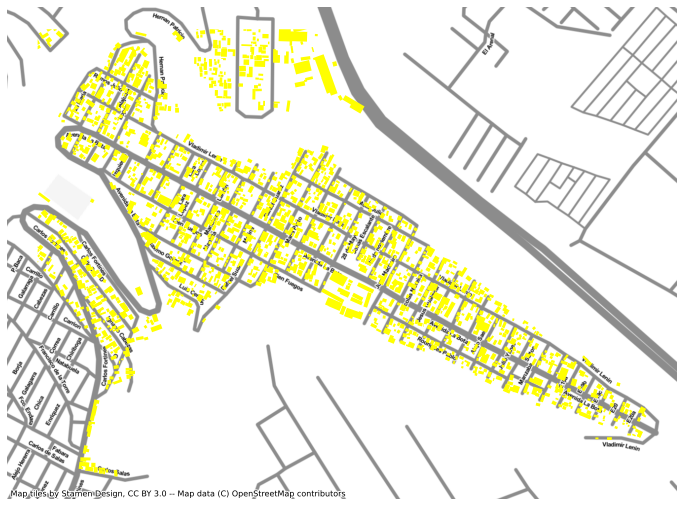

In [22]:
ax = LaBota_Buildings.plot(figsize=(12, 12), color="yellow")
contextily.add_basemap(
    ax, source=contextily.providers.Stamen.TonerLite, crs=LaBota_Buildings.crs.to_string()
)
ax.set_axis_off()

In [17]:
Toctiuco_Buildings.head()

,OBJECTID,DPA_MANZAN,DENSIDAD,AREA,geometry,index_right,quadkey
5,53023,17015018500701,172,4.5529,"MULTIPOLYGON (((-78.52539 -0.21406, -78.52544 ...",67436,210010000
5,53023,17015018500701,172,4.5529,"MULTIPOLYGON (((-78.52539 -0.21406, -78.52544 ...",41888,210010000
5,53023,17015018500701,172,4.5529,"MULTIPOLYGON (((-78.52539 -0.21406, -78.52544 ...",27727,210010000
5,53023,17015018500701,172,4.5529,"MULTIPOLYGON (((-78.52539 -0.21406, -78.52544 ...",223196,210010000
5,53023,17015018500701,172,4.5529,"MULTIPOLYGON (((-78.52539 -0.21406, -78.52544 ...",223197,210010000


In [23]:
Toctiuco_Buildings.explore()

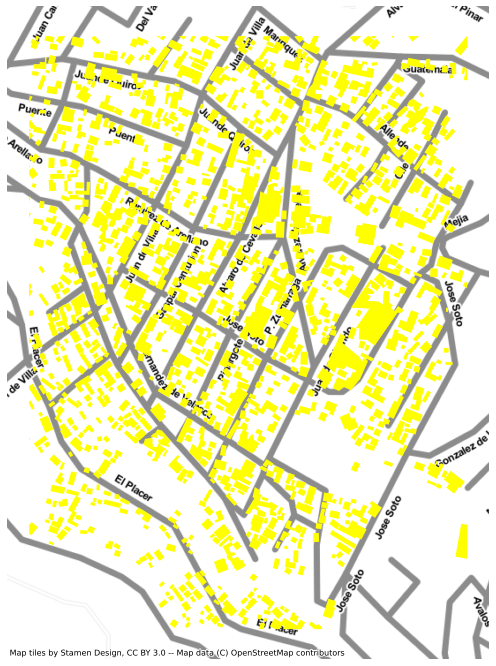

In [24]:
ax = Toctiuco_Buildings.plot(figsize=(12, 12), color="yellow")
contextily.add_basemap(
    ax, source=contextily.providers.Stamen.TonerLite, crs=Toctiuco_Buildings.crs.to_string()
)
ax.set_axis_off()